In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb

In [4]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

In [5]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [111]:
train=pd.read_csv('C:/Users/Aoos/Documents/Projects/HousePrice/train.csv')
test=pd.read_csv('C:/Users/Aoos/Documents/Projects/HousePrice/test.csv')

In [112]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

In [113]:
train = train.drop(train[train['SalePrice'] > 500000].index)

In [114]:
# log transformation
train["SalePrice"] = np.log1p(train["SalePrice"])

In [115]:
# remove outlier for LotFrontage and mean imputation
train = train.drop(train[train['LotFrontage']>150].index)
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())

In [116]:
# Removing outlier for LotArea and transforming
train = train.drop(train[train['LotArea']>50001].index)

In [45]:
all_data = all_data.reset_index()

In [117]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [118]:
# Some feature engineering 
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]

In [ ]:
# additional feature engineering

In [119]:
all_data = all_data.drop('Alley',1)
all_data['LotArea']=np.log1p(all_data['LotArea'])

In [120]:
all_data = all_data.drop('Condition2',1)

In [121]:
all_data = all_data.drop("BsmtFinSF1",1)
all_data = all_data.drop("BsmtFinSF2",1)

In [122]:
all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath",1)
all_data = all_data.drop("HalfBath",1)
all_data = all_data.drop("BsmtFullBath",1)
all_data = all_data.drop("BsmtHalfBath",1)   

In [123]:
#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [124]:
numeric_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotBsmtFin', 'TotBath'],
      dtype='object')

In [125]:
#for all the numeric features, calculate the skewness
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

In [126]:
#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

KeyError: '[  1.39151009   0.30330498   2.173152     0.16629822   0.68154043\n  -0.60603928  -0.49010001   2.58395659   0.91320296   0.41024087\n   0.86894213   0.76010864   9.18021827   0.79745899   0.25271588\n   4.4360774    0.6397792    0.6449891   -0.64195193  -0.33805498\n   0.1247772    1.4402787    2.3618908    2.85734785  10.19554159\n   4.15576007  19.34090972  24.29214951   0.21730323   0.09228819\n   0.51347523   0.22354603] not in index'

In [127]:
# creating new features - Old since house was built and renovated
all_data['YearsOld']=2014-all_data['YearBuilt']
all_data['YearsRemodel']=2014-all_data['YearRemodAdd']

In [128]:
all_data['YearsOld'].describe()

count    2892.000000
mean       42.803596
std        30.315398
min         4.000000
25%        13.000000
50%        41.000000
75%        61.000000
max       142.000000
Name: YearsOld, dtype: float64

In [129]:
all_data = all_data.drop('YearBuilt',1)
all_data = all_data.drop('YearRemodAdd',1)

In [130]:
#Drop some features that do not help
all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF",1)
all_data = all_data.drop("BedroomAbvGr",1)

In [131]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

In [132]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [133]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [142]:
#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
           for alpha in alphas]

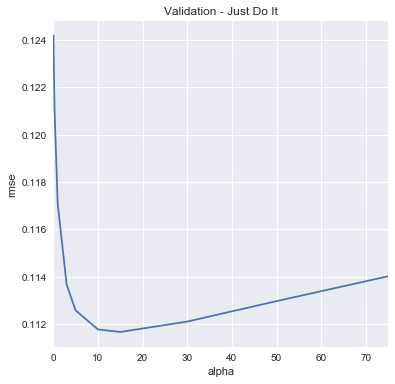

The min value of Ridge is  0.111655007352


In [143]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [144]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


C:\Users\Aoos\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Aoos\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Aoos\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Aoos\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase t

The min value of Lasso is  0.10960827812


In [145]:
#Lasso choose performs also feature selection 

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 100 variables and eliminated the other 165 variables


In [146]:
#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])

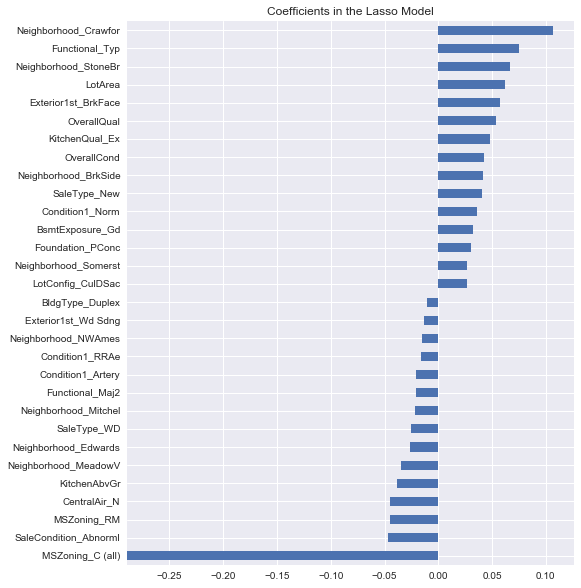

In [147]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")  
plt.show()

In [148]:
#Also note that unlike the feature importance you'd get from a random forest 
#these are actual coefficients in your model - so you can say precisely 
#why the predicted price is what it is. 
#The only issue here is that we log_transformed both the target 
#and the numeric features 
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

In [149]:
preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

In [150]:
preds_log["residuals"] = preds_log["true"] - preds_log["preds"]

In [75]:
#Let's add an xgboost model to our linear model to see 
#if we can improve our score:

In [151]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

In [152]:
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

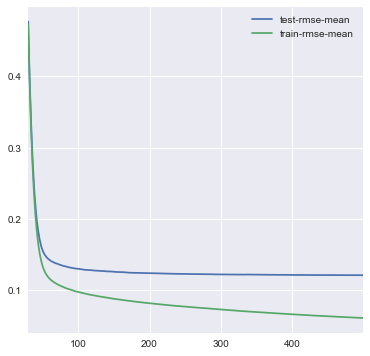

In [153]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

In [154]:
#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [155]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

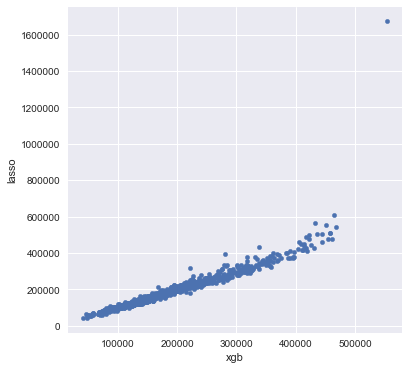

In [156]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
plt.show()

In [159]:
#Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves 
#the score although in this case it doesn't help that much.

preds = 0.60*lasso_preds + 0.40*xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})

In [160]:
solution.to_csv("C:/Users/Aoos/Documents/Projects/HousePrice/Solution/solution1.csv", index = False)